# Beiwe Homestay Data from GPS Traces
Peter provided the homestay data from the GPS traces and this notebook just helps take a look at it and process it for later use.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [2]:
import sys
import os
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Import
We have the files stored in the `interim` directory so we can import them by participant.

In [3]:
data_dir = "../"
data = pd.DataFrame()
for pt in os.listdir(f"{data_dir}data/interim/utx000-beiwe-homestay/"):
    temp = pd.read_csv(f"{data_dir}data/interim/utx000-beiwe-homestay/{pt}",parse_dates=["start","end"],infer_datetime_format=True)
    temp = temp.iloc[:,1:]
    temp["beiwe"] = pt.split("_")[1].split(".")[0]
    data = data.append(temp)

In [4]:
data.head()

,home.lat,home.long,start,end,nth.stay,beiwe
0,30.290428,-97.750645,2020-07-13 20:30:46,2020-07-14 05:08:52,1,i31pt4b4
1,30.290428,-97.750645,2020-07-14 05:48:53,2020-07-14 06:40:53,2,i31pt4b4
2,30.290428,-97.750645,2020-07-14 07:08:57,2020-07-14 07:39:15,3,i31pt4b4
3,30.290428,-97.750645,2020-07-14 08:14:59,2020-07-14 09:32:53,4,i31pt4b4
4,30.290428,-97.750645,2020-07-14 20:16:46,2020-07-15 08:36:58,5,i31pt4b4


# Inspection
We can look at a few derivatives.

In [5]:
data["t"] = (data["end"] - data["start"]).dt.total_seconds()

## Comparing Lat/Long from Beiwe to Provided Address

In [16]:
# Importing the data
info = pd.read_excel("../data/raw/utx000/admin/id_crossover.xlsx",sheet_name="beacon")
info = info[["beiwe","lat","long","lat2","long2"]]
# filtering dataset
add = data.groupby("beiwe").median().reset_index()
add.rename({"home.lat":"lat","home.long":"long"},axis="columns",inplace=True)

In [20]:
merged = add.merge(right=info,on="beiwe",suffixes=["_hagen","_peter"])
merged

,beiwe,lat_hagen,long_hagen,nth.stay,t,lat_peter,long_peter,lat2,long2
0,2xtqkfz1,32.923087,-96.962828,5.5,39640.5,32.923090,-96.962800,NaN,NaN
1,4i7679py,33.035997,-96.653704,64.5,9944.0,33.035980,-96.653690,NaN,NaN
2,745vq78e,30.288063,-97.748945,48.0,13522.0,29.615620,-98.644590,NaN,NaN
3,9jtzsuu8,33.142014,-97.113499,80.5,7120.0,33.142000,-97.113500,NaN,NaN
4,9xmhtq74,30.757023,-94.417857,26.5,24355.0,30.758533,-94.420724,30.283576,-97.735383
5,awa8uces,30.049387,-95.505522,44.5,39906.0,30.049390,-95.505500,NaN,NaN
6,e73a1pd5,26.240967,-98.220363,8.0,34418.0,26.241182,-98.220823,30.293238,-97.745539
7,hxj6brwj,30.280121,-97.741183,35.0,12037.0,30.280070,-97.741150,NaN,NaN
8,i31pt4b4,30.290428,-97.750645,51.0,16966.0,30.290360,-97.750660,NaN,NaN
9,idbkjh8u,30.237509,-97.710649,6.0,20297.0,30.240268,-97.709502,30.284696,-97.747237


In [33]:
def plot_bar(df,lat1,lat2,long1,long2):
    """"""
    lat_diff = abs(df[lat1] - df[lat2])
    long_diff = abs(df[long1] - df[long2])

    x = np.arange(len(df))
    width = 0.4

    fig, ax = plt.subplots(figsize=(16,6))
    rects1 = ax.bar(x - width/2, lat_diff, width, label='Lat', color="cornflowerblue", edgecolor="black")
    rects2 = ax.bar(x + width/2, long_diff, width, label='Long', color="seagreen", edgecolor="black")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Absolute Difference in Coordinates')
    ax.set_xticks(x)
    ax.set_xticklabels(df["beiwe"],rotation=-30,ha="left")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    ax.legend()

    plt.show()


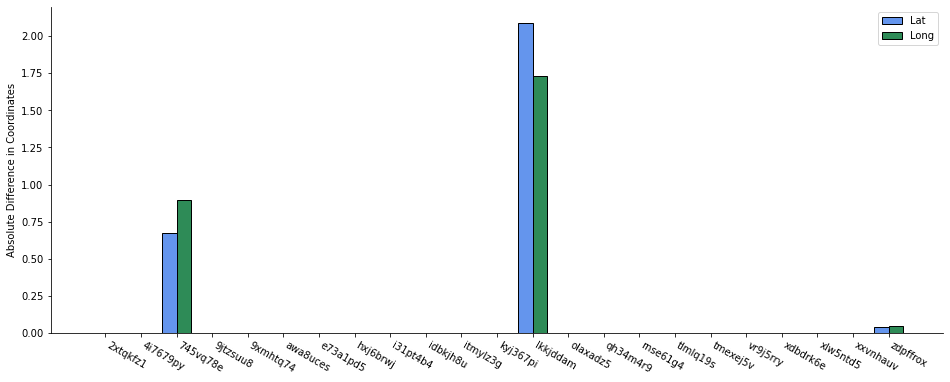

In [34]:
plot_bar(merged,"lat_hagen","lat_peter","long_hagen","long_peter")

# Saving

In [29]:
data.to_csv("../data/processed/beiwe-homestay-ux_s20.csv")